In [8]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV, ElasticNetCV
ols = LinearRegression()
ridge = Ridge()
lasso  = Lasso()
lassocv = LassoCV()
elasticnet = ElasticNet()
elasticnetcv = ElasticNetCV()
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.feature_selection as fs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# The tree model
from sklearn import tree
# Instantiating the tree model (regression type)
regressor = tree.DecisionTreeRegressor()
# The ensemble model for random forest and bagging
from sklearn import ensemble
# Instantiating the ensemble models
randomForest = ensemble.RandomForestRegressor()
bagging      = ensemble.BaggingRegressor()
gbm          = ensemble.GradientBoostingRegressor()
abr          = ensemble.AdaBoostRegressor()
from sklearn import metrics

### Functions

In [9]:
#define function to split into train and test sets
def split_sets(dataframe, seed, test_prop=0.3): 
    '''
    - A function that splits specifically the housing data set into train and test sets
    - Requires multiple assignment: trainX, testX, trainY, testY
    ---------------
    - dataframe: dataframe to be split
    - seed: set seed for reproducability
    - test_prop: takes a float - proportion of dataframe that should be allocated to the test set
    '''

    y=dataframe.SalePrice
    X=dataframe.drop('SalePrice', axis=1)

    np.random.seed(seed)
    testIdxes = np.random.choice(range(0,dataframe.shape[0]), size=round(dataframe.shape[0]*test_prop), replace=False)
    trainIdxes = list(set(range(0,dataframe.shape[0])) - set(testIdxes))

    trainX = X.iloc[trainIdxes,:]
    testX  = X.iloc[testIdxes,:]
    trainY = y.iloc[trainIdxes]
    testY  = y.iloc[testIdxes]
    
    return trainX, testX, trainY, testY

In [10]:
def important_coefs_lasso(model, dataframe):
    '''
    - A function that returns non-zero coefficients in order from a lasso model output
    ---------------
    - dataframe: dataframe of model inputs
    - model: model object
    '''
    lassoCoef = pd.Series(model.coef_, index=dataframe.columns)
    lassoCoef=lassoCoef[np.abs(lassoCoef)>0]
    return lassoCoef.sort_values(ascending=False)

In [11]:
def sort_ridge_coefs(model, dataframe):
    ridge_coef = pd.Series(model.coef_, index=dataframe.columns)
    ridge_coef.sort_values(ascending=False)
    order = abs(ridge_coef).sort_values(ascending=False)
    return ridge_coef[order.index]

### Create Train/Test Split

In [13]:
#read in dataframe, give the dataset a unique name
df = pd.read_csv('purged_dummified_grouped_baseline_df', index_col='Id')

In [15]:
trainX, testX, trainY, testY = split_sets(df, 0, 0.3)

### Lasso Model

#### *Grid Search for Optimal Alpha*

In [16]:
#define alpha range and train lasso model
alphaRange = np.linspace(10e-6,0.05,100)

grid_param=[{'alpha': alphaRange}]
para_search = GridSearchCV(estimator=Lasso(max_iter=5000),\
                           param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search.fit(trainX, trainY)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([1.00000e-05, 5.14949e-04, ..., 4.94951e-02, 5.00000e-02])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

#### *Visualize Grid Search Results*

Best Test MSE: 0.00829675126648495
Best Alpha: 0.00101989898989899


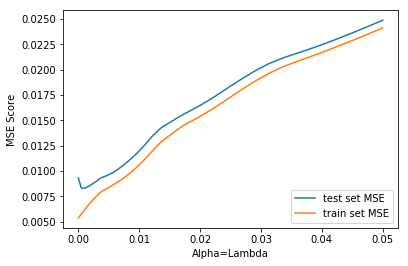

In [17]:
#plot cross validation results
plt.plot(alphaRange,-1*para_search.cv_results_['mean_test_score'], label=r'test set MSE')
plt.plot(alphaRange,-1*para_search.cv_results_['mean_train_score'], label=r'train set MSE')
plt.legend(loc=4)

plt.xlabel('Alpha=Lambda')
plt.ylabel('MSE Score')
lasso_best_score = para_search.best_score_
lasso_best_alpha = para_search.best_params_['alpha']
print('Best Test MSE: %s' %(abs(lasso_best_score)))
print('Best Alpha: %s' %(lasso_best_alpha))

#### *Lasso Results on Test Set*

In [18]:
lasso.set_params(alpha=lasso_best_alpha, normalize = False)
lasso.fit(trainX,trainY)
l_MSE = np.mean((lasso.predict(testX)-testY)**2)
l_RMSE_in_dollars = np.mean((np.exp(lasso.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(l_MSE))
print('Test RMSE in $$: %s' %(l_RMSE_in_dollars))

Test MSE: 0.010481788728254946
Test RMSE in $$: 14124.639160126959


In [19]:
important_coefs_lasso(lasso, trainX)

RoofMatl__4         0.190173
Neighborhood__16    0.076223
RoofMatl__1         0.072725
YearBuilt           0.050614
GrLivArea           0.050178
OverallQual         0.045080
OverallCond         0.033224
Condition2__3       0.024561
Neighborhood__7     0.022545
Fence__1            0.017743
TotalBsmtSF         0.017651
GarageArea          0.014835
1stFlrSF            0.013469
BsmtFullBath        0.012692
GarageCond          0.011832
LotArea             0.011229
Neighborhood__8     0.010752
MSZoning__1         0.010135
Neighborhood__17    0.009511
HalfBath            0.009289
KitchenQual         0.008882
LotFrontage         0.008466
FireplaceQu         0.008372
BsmtFinType1__2     0.007729
BsmtExposure        0.007026
SaleCondition__2    0.005865
Foundation__3       0.005468
MSSubClass__2       0.004066
YearRemodAdd        0.003828
Exterior1st__3      0.003617
BsmtHalfBath        0.003003
ExterQual           0.002905
ExterCond           0.001957
GarageFinish__2     0.001953
BsmtQual      

### Ridge Model

#### *Grid Search for Optimal Alpha*

In [20]:
#define alpha range and train ridge model
r_alphaRange = np.linspace(10e-3,100,100)

r_grid_param=[{'alpha': r_alphaRange}]
r_para_search = GridSearchCV(estimator=Ridge(max_iter=5000),\
                           param_grid=r_grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
r_para_search.fit(trainX, trainY)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([1.000e-02, 1.020e+00, ..., 9.899e+01, 1.000e+02])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

#### *Visualize Grid Search Results*

Best Test MSE: 0.008584510271319378
Best Alpha: 8.09


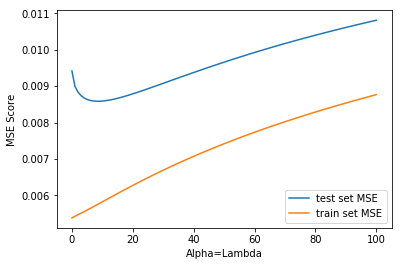

In [21]:
#plot cross validation results
plt.plot(r_alphaRange,-1*r_para_search.cv_results_['mean_test_score'], label=r'test set MSE')
plt.plot(r_alphaRange,-1*r_para_search.cv_results_['mean_train_score'], label=r'train set MSE')
plt.legend(loc=4)

plt.xlabel('Alpha=Lambda')
plt.ylabel('MSE Score')
ridge_best_score = r_para_search.best_score_
ridge_best_alpha = r_para_search.best_params_['alpha']
print('Best Test MSE: %s' %(abs(ridge_best_score)))
print('Best Alpha: %s' %(ridge_best_alpha))

#### *Ridge Results on Test Set*

In [22]:
ridge.set_params(alpha=ridge_best_alpha, normalize = False)
ridge.fit(trainX,trainY)
r_MSE = np.mean((ridge.predict(testX)-testY)**2)
r_RMSE_in_dollars = np.mean((np.exp(ridge.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(r_MSE))
print('Test RMSE in $$: %s' %(r_RMSE_in_dollars))

Test MSE: 0.010609656261846004
Test RMSE in $$: 13764.283657420083


In [23]:
sort_ridge_coefs(ridge, trainX)

RoofMatl__2        -0.107053
Condition2__1      -0.107053
RoofMatl__4         0.103818
Condition2__3       0.082542
Neighborhood__16    0.079224
Neighborhood__6    -0.058630
Heating__2         -0.051136
YearBuilt           0.047915
OverallQual         0.042578
Neighborhood__17    0.037183
GrLivArea           0.036333
MSSubClass__4      -0.035933
SaleCondition__1   -0.035505
Condition2__4       0.035411
MSZoning__2         0.033508
OverallCond         0.033411
Neighborhood__7     0.033217
Neighborhood__2    -0.030395
RoofMatl__1         0.029886
1stFlrSF            0.028181
MSZoning__1         0.026912
Heating__1         -0.025888
MSSubClass__5      -0.023024
Fence__1            0.022849
Neighborhood__8     0.021399
Exterior1st__3      0.019225
BsmtFinType1__5    -0.018339
BldgType__1         0.017874
GarageFinish__1    -0.017868
MSSubClass__8       0.017712
MSSubClass__6      -0.016980
TotalBsmtSF         0.016631
2ndFlrSF            0.016416
BsmtFinType1__6    -0.016053
Exterior2nd__7

### Elastic Net Model

#### *Grid Search for Optimal Alpha*

In [24]:
#define alpha range and train elastic net model
alphaSize = 100
rhoSize = 10
e_alphaRange = np.linspace(10e-4, 20, alphaSize)
l1_ratio = np.linspace(0.1, 1, rhoSize)

e_grid_param=[{'alpha': e_alphaRange, 'l1_ratio': l1_ratio}]
e_para_search = GridSearchCV(estimator=ElasticNet(max_iter=2000),\
                           param_grid=e_grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
e_para_search.fit(trainX, trainY)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([1.0000e-03, 2.0301e-01, ..., 1.9798e+01, 2.0000e+01]), 'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

#### *Output eNet Params*

In [25]:
e_best_alpha = e_para_search.best_params_['alpha']
e_best_l1ratio = list(e_para_search.best_params_.values())[1]
e_best_score = r_para_search.best_score_
print('Best Test MSE: %s' %(abs(e_best_score)))
print('Best Alpha: %s' %(e_best_alpha))
print('Best Rho: %s' %(e_best_l1ratio))

Best Test MSE: 0.008584510271319378
Best Alpha: 0.001
Best Rho: 0.8


#### *eNet Results on Test Set*

In [26]:
elasticnet.set_params(alpha=e_best_alpha, l1_ratio = e_best_l1ratio, normalize = False)
elasticnet.fit(trainX,trainY)
e_MSE = np.mean((elasticnet.predict(testX)-testY)**2)
e_RMSE_in_dollars = np.mean((np.exp(elasticnet.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(e_MSE))
print('Test RMSE in $$: %s' %(e_RMSE_in_dollars))

Test MSE: 0.010389073638758045
Test RMSE in $$: 13966.44737755994


In [27]:
sort_ridge_coefs(elasticnet, trainX)

RoofMatl__4         0.177527
Condition2__1      -0.121019
RoofMatl__2        -0.115157
Neighborhood__16    0.083618
RoofMatl__1         0.065597
Neighborhood__6    -0.050451
GrLivArea           0.049829
Heating__2         -0.048766
YearBuilt           0.048744
OverallQual         0.043941
Condition2__3       0.043555
OverallCond         0.032977
SaleCondition__1   -0.031643
Neighborhood__7     0.027084
MSSubClass__4      -0.024478
Neighborhood__17    0.020334
Fence__1            0.019053
Neighborhood__2    -0.018057
TotalBsmtSF         0.017655
GarageArea          0.014796
GarageFinish__1    -0.014305
Neighborhood__8     0.013910
Condition2__4       0.013742
1stFlrSF            0.013620
BsmtFullBath        0.012946
GarageCond          0.011689
MSZoning__1         0.011625
LotArea             0.011462
HalfBath            0.009753
LotFrontage         0.009026
KitchenQual         0.008807
Foundation__3       0.008432
BsmtFinType1__2     0.008329
SaleCondition__2    0.008105
FireplaceQu   

### CV Bagging

In [30]:
# Use double underscore to indicate this parameter "belongs":
# base_estimator__ <-- belongs to base_estimator (use __)
# Other parameters without __ (double underscore) are parameters for the bagging classifier

# TAKES TOO LONG TO RUN PARAM_GRID2
# param_grid2 = {
#     'base_estimator__min_samples_leaf' : range(2, 13),\
#     'base_estimator__min_samples_split': range(2, 21),\
#     'n_estimators' : range(100,600,100),\
#     'max_samples' : [0.3, 0.6, 0.9],\
#     'max_features': [0.25,0.5,0.75]
# }
param_grid = {
    'max_samples' : np.linspace(0.1,0.9,9),\
    'max_features': np.linspace(0.1,0.9,9)
}
grid_search_bag = GridSearchCV(ensemble.BaggingRegressor(base_estimator=tree.DecisionTreeRegressor(criterion="mse",splitter="best",min_samples_leaf=2,min_samples_split=15),\
                                                         n_estimators=100,bootstrap=True,oob_score = True,n_jobs=-1,random_state=0),\
                               param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,refit=True)
%time grid_search_bag.fit(trainX, trainY)

# Print results    
print('Best parameters: {}'.format(grid_search_bag.best_params_))
print('Best MSE Score: {0:.3f}'.format(-grid_search_bag.best_score_)) # NOTE: it is negated! (Sklearn convention)
print('MSE Score on training data set (using best parameters): {0:.6f}'.format(-grid_search_bag.score(trainX, trainY)))
print('MSE Score on test data set (using best parameters): {0:.6f}'.format(-grid_search_bag.score(testX, testY)))
print('RMSE in $$ on test data set (using best parameters): {0:.1f}'.format(\
      np.mean((np.exp(grid_search_bag.predict(testX))-np.exp(testY))**2)**0.5))

CPU times: user 2.32 s, sys: 169 ms, total: 2.49 s
Wall time: 58.6 s
Best parameters: {'max_features': 0.6, 'max_samples': 0.8}
Best MSE Score: 0.009
MSE Score on training data set (using best parameters): 0.004691
MSE Score on test data set (using best parameters): 0.012687
RMSE in $$ on test data set (using best parameters): 13923.688071


#### *Visualize Grid Search Results*

In [ ]:
xplot=list(param_grid['max_samples'])
yplot=list(param_grid['max_features'])
zplot=-1*grid_search_bag.cv_results_['mean_test_score'].reshape(len(yplot),-1) # NOTE: it is negated! (Sklearn convention)
plt.pcolor(xplot,yplot,zplot,cmap='RdBu')
plt.colorbar();
plt.xlabel('Maximum Number of Samples for Bootstrap (%)');
plt.ylabel('Max Features to Consider for Each Split');

#### *Visualize MSE*

In [ ]:
number_estimators = range(10, 110,10)
train_error = []
test_error = []
for i in number_estimators:
    bagging.set_params(n_estimators=i,bootstrap=True,oob_score = False,n_jobs=-1,random_state=0,\
                       max_samples=0.6,max_features=0.5)
    bagging.fit(trainX, trainY)
    train_error.append(metrics.mean_squared_error(y_train, bagging.predict(x_train))) 
    test_error.append(metrics.mean_squared_error(y_test, bagging.predict(x_test))) 
import matplotlib.pyplot as plt
plt.plot(number_estimators, train_error, c='red', label='training error')
plt.plot(number_estimators, test_error, c='blue', label='test error')
plt.ylabel('MSE')
plt.xlabel('Number of Trees')
plt.legend()
plt.show()

### Random Forests

In [31]:
param_grid = {
    'max_depth' : range(5,20),\
    'max_features': range(5,20)
}
randomForest = ensemble.RandomForestRegressor()
grid_search_forest = GridSearchCV(ensemble.RandomForestRegressor(n_estimators=100,criterion="mse",\
                                                                 min_samples_leaf=2,min_samples_split=2,\
                                                                 bootstrap=True,oob_score = True,n_jobs=-1),\
                                  param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,refit=True)
%time grid_search_forest.fit(trainX, trainY)

# Print results    
print('Best parameters: {}'.format(grid_search_forest.best_params_))
print('Best MSE Score: {0:.3f}'.format(-grid_search_forest.best_score_)) # NOTE: it is negated! (Sklearn convention)
print('MSE Score on training data set (using best parameters): {0:.3f}'.format(-grid_search_forest.score(trainX, trainY)))
print('MSE Score on test data set (using best parameters): {0:.3f}'.format(-grid_search_forest.score(testX, testY)))
print('RMSE in $$ on test data set (using best parameters): {0:.1f}'.format(\
      np.mean((np.exp(grid_search_forest.predict(testX))-np.exp(testY))**2)**0.5))

CPU times: user 6.36 s, sys: 392 ms, total: 6.75 s
Wall time: 1min 59s
Best parameters: {'max_depth': 13, 'max_features': 19}
Best MSE Score: 0.009
MSE Score on training data set (using best parameters): 0.003
MSE Score on test data set (using best parameters): 0.013
RMSE in $$ on test data set (using best parameters): 13571.0


#### *Visualize Grid Search Results*

In [ ]:
xplot=list(param_grid['max_depth'])
yplot=list(param_grid['max_features'])
zplot=-1*grid_search_forest.cv_results_['mean_test_score'].reshape(len(yplot),-1) # NOTE: it is negated! (Sklearn convention)
plt.pcolor(xplot,yplot,zplot,cmap='RdBu')
plt.colorbar();
plt.xlabel('Maximum Tree Depth');
plt.ylabel('Max Features to Consider for Each Split');

#### *Visualize MSE*

In [ ]:
number_estimators = range(10,110,10)
train_error = []
test_error = []
for i in number_estimators:
    randomForest.set_params(n_estimators=i,criterion="mse",bootstrap=True,oob_score = False,n_jobs=-1,random_state=0,\
                       max_depth=5,max_features=5)
    randomForest.fit(trainX, trainY)
    train_error.append(metrics.mean_squared_error(y_train, randomForest.predict(x_train))) 
    test_error.append(metrics.mean_squared_error(y_test, randomForest.predict(x_test))) 
import matplotlib.pyplot as plt
plt.plot(number_estimators, train_error, c='red', label='training error')
plt.plot(number_estimators, test_error, c='blue', label='test error')
plt.ylabel('MSE')
plt.xlabel('Number of Trees')
plt.legend()
plt.show()

In [ ]:
#visualize best predictors
feature_importance = list(zip(x_train.columns, randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:20].plot.bar(x='name', y='score')

### Store Outputs

In [36]:
#index = ['Lasso', 'Ridge', 'eNet', 'Bagged_Tree', 'Rand_Forests']
#scores = [l_MSE, r_MSE, e_MSE, -grid_search_bag.score(testX, testY), -grid_search_forest.score(testX, testY)]
#model_results = pd.DataFrame(data=scores,index=index, columns = ['purged_dummified_grouped_baseline_df'])

In [ ]:
# fill in name of dataframe
model_results['?'] = [l_MSE, r_MSE, e_MSE, -grid_search_bag.score(testX, testY), -grid_search_forest.score(testX, testY)]

In [37]:
model_results

,purged_dummified_grouped_baseline_df
Lasso,0.010482
Ridge,0.010610
eNet,0.010389
Bagged_Tree,0.012687
Rand_Forests,0.012598
